In [5]:
import configs
import torch 
import pickle as pkl
import tiled_events as te
import matplotlib.pyplot as plt
import posteriors as pos
import seaborn as sns 
import numpy as np
import raw_events as rev
config_name = "full_priors_restrict_azimuth"
config = configs.config_dict[config_name]
results_dir = "/home/export/ajshen/ada-sbi-cosmic-rays/results/"
out_dir = results_dir + f"{config_name}_{config.seed}/"
DEVICE = torch.device(f"cuda:{config.gpu_index}")

model = config.model_constructor(
    DEVICE,
    len(config.time_averages), 
    torch.tensor(config.detector_layout.shape)/config.downsample_factor
)
model.load_state_dict(torch.load(results_dir + config.model_save_path))
model.eval()

with open(out_dir + "train_feature_maxes.pkl", 'rb') as file:
    train_feature_maxes = pkl.load(file)
    

qr = pos.waldo_qr(
    config.confidence_levels[0],
    None,
    model,
    None,
    config.train_param_mins,
    config.train_param_maxes,
    out_dir,
    num_posterior_samples=config.calibration_num_posterior_samples,
    cal_loader_repeats=config.cal_loader_repeats
)

with open(f"../{config.source_data_config.splits_dir}test.pkl", "rb") as file:
    test_ds = te.CRImageDataset(
        events=pkl.load(file),
        downsample_factor=config.downsample_factor,
        detector_layout=config.detector_layout,
        max_shift_radius=config.max_shift_radius,
        min_nonzero_features=config.min_features_threshold,
        sample_ratio=0.1,
        restrict_to_pm90=config.restrict_azimuth_to_pm90deg,
        device=DEVICE
    )

test_ds.set_feature_scale(train_feature_maxes)
test_ds.set_param_weighter(-1)

with open("../vsi_all_manifest_filtered_flexible_priors.pkl", 'rb') as file:
    manifest = pkl.load(file)

100%|██████████| 42757/42757 [00:28<00:00, 1496.07it/s]


In [1]:
import configs
import torch 
import pickle as pkl
import tiled_events as te
import matplotlib.pyplot as plt
import posteriors as pos
import seaborn as sns 
import numpy as np
import raw_events as rev

with open("../vsi_all_manifest_filtered_flexible_priors.pkl", 'rb') as file:
    manifest = pkl.load(file)
    
with open("../vsi_all_manifest.pkl", 'rb') as file:
    unfiltered_manifest = pkl.load(file)

/home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
split_df = manifest[manifest["split"] == 3]
test = te.SplitParameterWeights(unfiltered_manifest, split_df, rev.differential_mrk421_flux, 40)

/tmp/user/3387/ipykernel_342385/3896139098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_df["weight"] = test.get_weight(split_df["log10_energy"], split_df["zenith"])


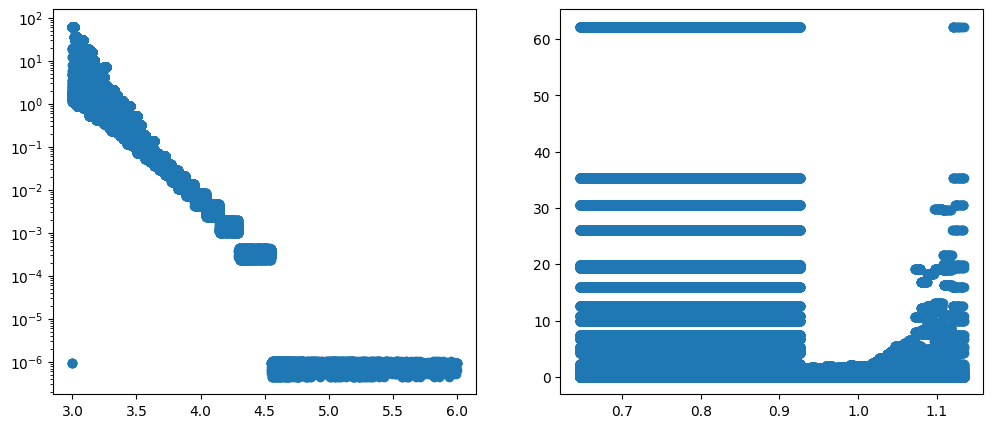

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
split_df = manifest[manifest["split"] == 1]
split_df["weight"] = test.get_weight(split_df["log10_energy"], split_df["zenith"])
ax[0].scatter(split_df["log10_energy"], split_df["weight"])
ax[0].set_yscale("log")
ax[1].scatter(split_df["zenith"], split_df["weight"])

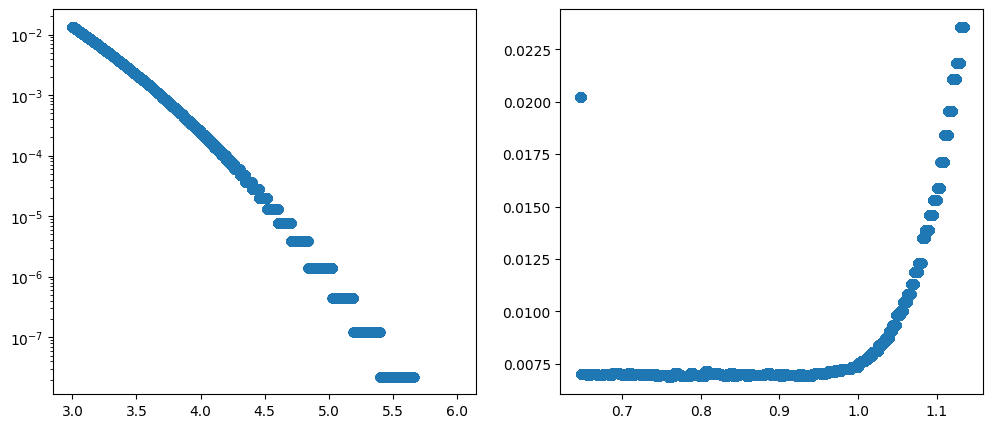

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
split_df = manifest[manifest["split"] == 1]
ax[0].scatter(split_df["log10_energy"], split_df["energy_weight"])
ax[0].set_yscale("log")
ax[1].scatter(split_df["zenith"], split_df["zenith_weight"])

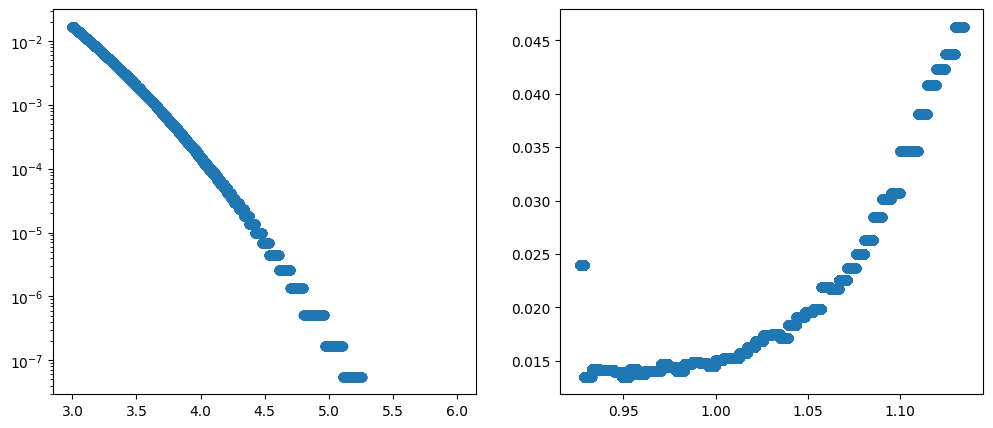

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
split_df = manifest[manifest["split"] == 3]
ax[0].scatter(split_df["log10_energy"], split_df["energy_weight"])
ax[0].set_yscale("log")
ax[1].scatter(split_df["zenith"], split_df["zenith_weight"])

Text(0.5, 1.0, 'Trajectories of Crab and Mrk421 from -15 deg latitude')

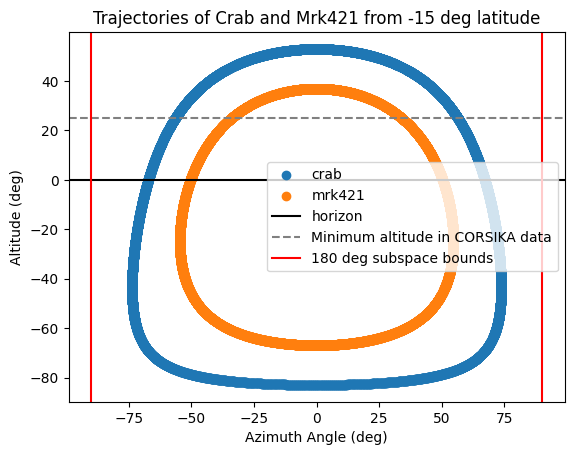

In [13]:
crab_trajectory = rev.get_source_trajectory("crab", -15)
mrk_trajectory = rev.get_source_trajectory("mrk421", -15)
fig, ax = plt.subplots()
ax.scatter((np.array(crab_trajectory.az) + 180) % 360 - 180, crab_trajectory.alt, label="crab")
ax.scatter((np.array(mrk_trajectory.az) + 180) % 360 - 180, mrk_trajectory.alt, label="mrk421")
ax.set_xlabel("Azimuth Angle (deg)")
ax.set_ylabel("Altitude (deg)")
ax.axhline(0, color="black", label="horizon")
ax.axhline(25, color="grey", label="Minimum altitude in CORSIKA data", linestyle="dashed")
ax.axvline(-90, color="red", label="180 deg subspace bounds")
ax.axvline(90, color="red")
ax.legend()
ax.set_title("Trajectories of Crab and Mrk421 from -15 deg latitude")

In [33]:
with open("../vsi_all_manifest_filtered_flexible_priors_uniform_test.pkl", 'rb') as file:
    manifest = pkl.load(file)
len(manifest)

49978840

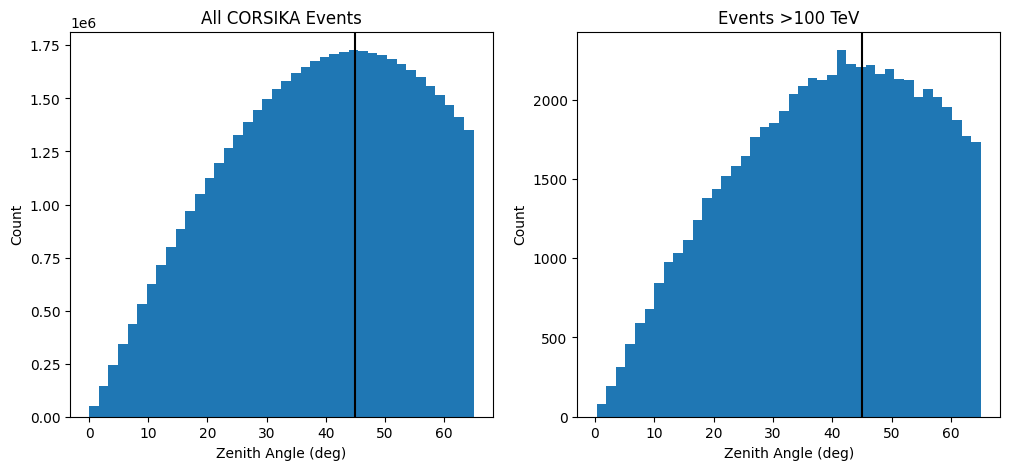

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(np.rad2deg(manifest["zenith"]), bins=40)
for a in range(2):
    ax[a].set_xlabel("Zenith Angle (deg)")
    ax[a].set_ylabel("Count")
# ax.hist(manifest.query("energy > 1000")["zenith"], bins=40)
# ax.hist(manifest.query("energy > 10000")["zenith"], bins=40)
ax[0].set_title("All CORSIKA Events")
ax[1].set_title("Events >100 TeV")
ax[1].hist(np.rad2deg(manifest.query("energy > 100_000")["zenith"]), bins=40)
ax[0].axvline(45, color="black")
ax[1].axvline(45, color="black")

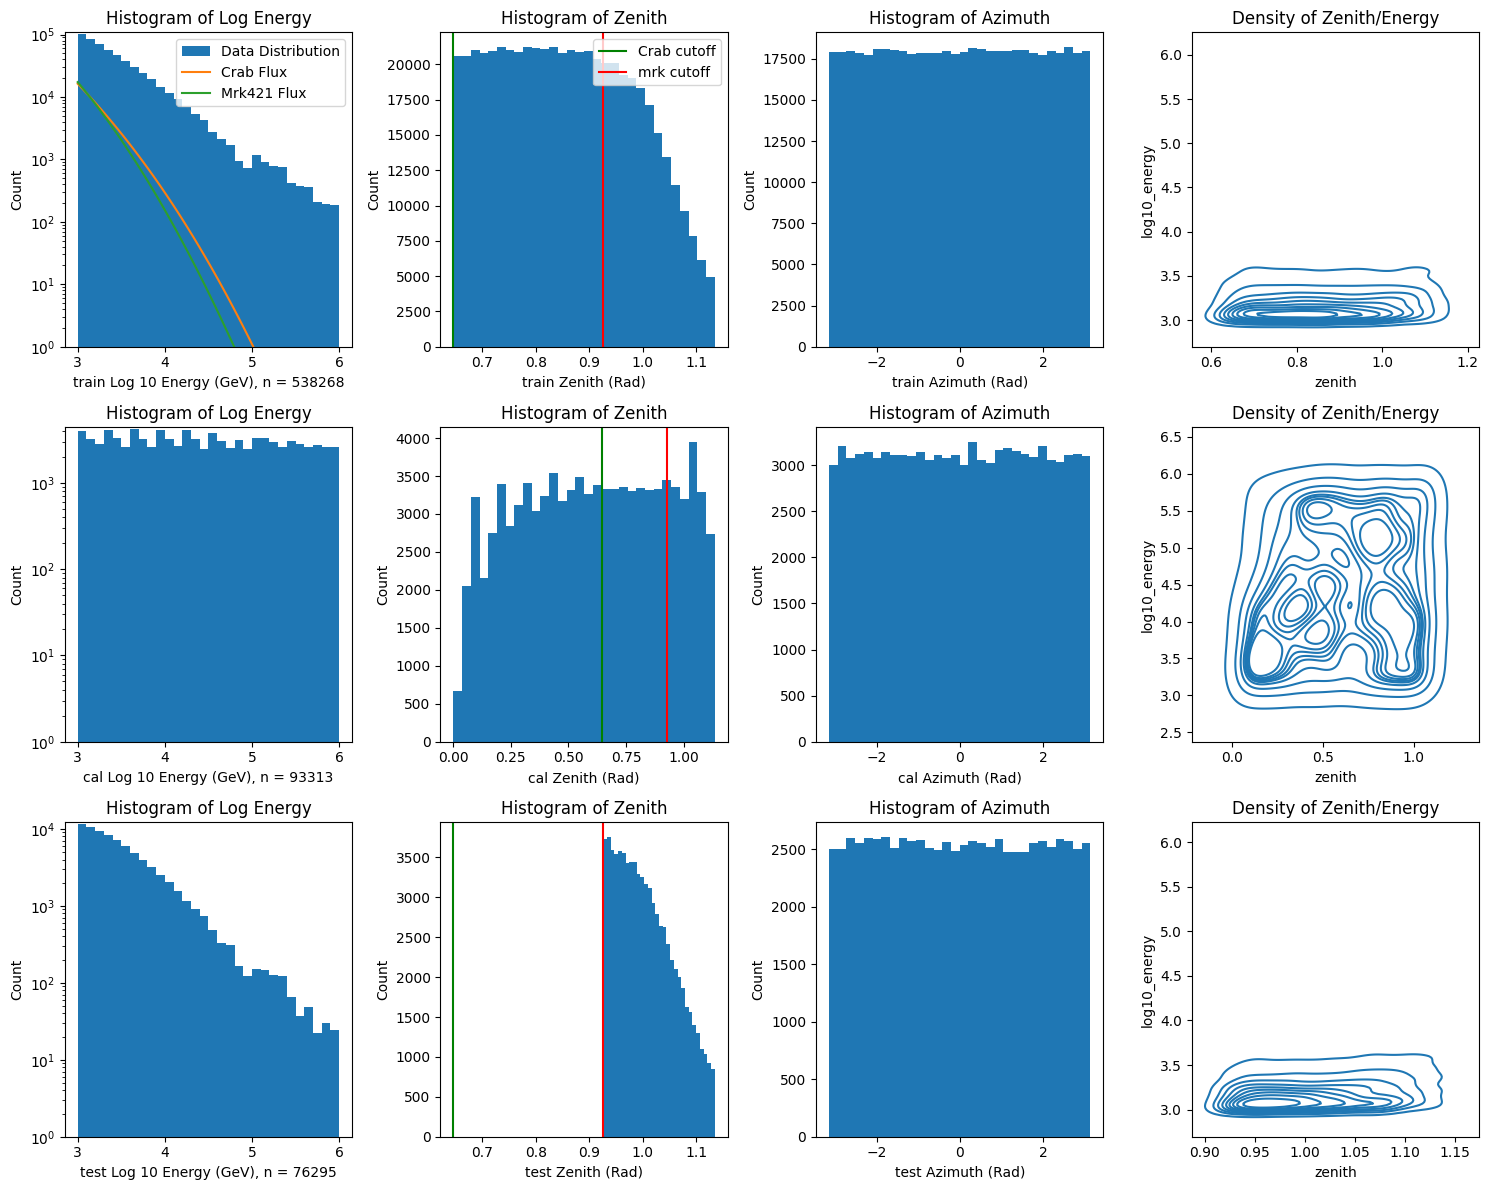

In [3]:


fig, ax = plt.subplots(3, 4, figsize=(15, 12))
num_bins=30
flux_grid = np.linspace(3, 6, 100)
crab_trajectory = rev.get_source_trajectory("crab", -15)
mrk_trajectory = rev.get_source_trajectory("mrk421", -15)
crab_min_zenith = np.deg2rad(90 - np.max(np.array(crab_trajectory.alt)))
mrk_min_zenith = np.deg2rad(90 - np.max(np.array(mrk_trajectory.alt)))

for i, split in zip(range(3), ["train", "cal", "test"]):
    split_df = manifest[manifest["split"] == i + 1]
    nonzero_df = split_df.query("num_features >= 10")
    ax[i, 0].hist(split_df["log10_energy"], bins=num_bins, label="Data Distribution")
    # ax[i, 0].hist(nonzero_df["log10_energy"], bins=num_bins, alpha=0.6, label="Data Distribution (# features > 0)")
    if i == 0:
        ax[i, 0].plot(flux_grid, 10**rev.log10_crab_flux(flux_grid) * 5e14, label="Crab Flux")
        ax[i, 0].plot(flux_grid, 10**rev.log10_mrk421_flux(flux_grid) * 5e14, label="Mrk421 Flux")
        ax[i, 0].legend()
    ax[i, 0].set_xlabel(f"{split} Log 10 Energy (GeV), n = {len(nonzero_df)}")
    ax[i, 0].set_ylim(bottom=1)
    ax[i, 0].set_yscale("log")
    ax[i, 0].set_title("Histogram of Log Energy")
    
    ax[i, 1].hist(split_df["zenith"], bins=num_bins)
    # ax[i, 1].hist(nonzero_df["zenith"], bins=num_bins, alpha=0.6)
    ax[i, 1].set_xlabel(f"{split} Zenith (Rad)")    
    ax[i, 1].axvline(crab_min_zenith, label="Crab cutoff", color="green")
    ax[i, 1].axvline(mrk_min_zenith, label="mrk cutoff", color="red")
    ax[i, 1].set_title("Histogram of Zenith")
    if i == 0:
        ax[i, 1].legend()
    
    ax[i, 2].set_title("Histogram of Azimuth")
    ax[i, 2].hist(split_df["azimuth"], bins=num_bins, label="Original Data Distribution")
    # ax[i, 2].hist(nonzero_df["azimuth"], bins=num_bins, alpha=0.6, label="Data Distribution (# features > 0)")
    ax[i, 2].set_xlabel(f"{split} Azimuth (Rad)")    
    
    kde_df = nonzero_df.sample(n=5_000)
    sns.kdeplot(x=kde_df["zenith"], y = kde_df["log10_energy"], ax = ax[i, 3], weights= None if i == 1 else kde_df["energy_weight"] * kde_df["zenith_weight"])
    ax[i, 3].set_title("Density of Zenith/Energy")
    
    for j in range(3):
        ax[i, j].set_ylabel("Count")
    
        
fig.tight_layout()

In [13]:
manifest[manifest["split"] == 1]["num_features"].min()

10

In [2]:
import cr_sources as crs
crab_trajectory = crs.get_source_trajectory("crab", -15)

In [5]:
crab_min_zenith = np.deg2rad(90 - np.array(crab_trajectory.alt).max())
crab_min_zenith

0.6463221858348408

In [24]:
precomputed_weighters = [None, None, None]

/tmp/user/3387/ipykernel_352603/2842190104.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_df["weight"] = weighter.get_weight(split_df["log10_energy"], split_df["zenith"])
/tmp/user/3387/ipykernel_352603/2842190104.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_df["weight"] = weighter.get_weight(split_df["log10_energy"], split_df["zenith"])
/tmp/user/3387/ipykernel_352603/2842190104.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

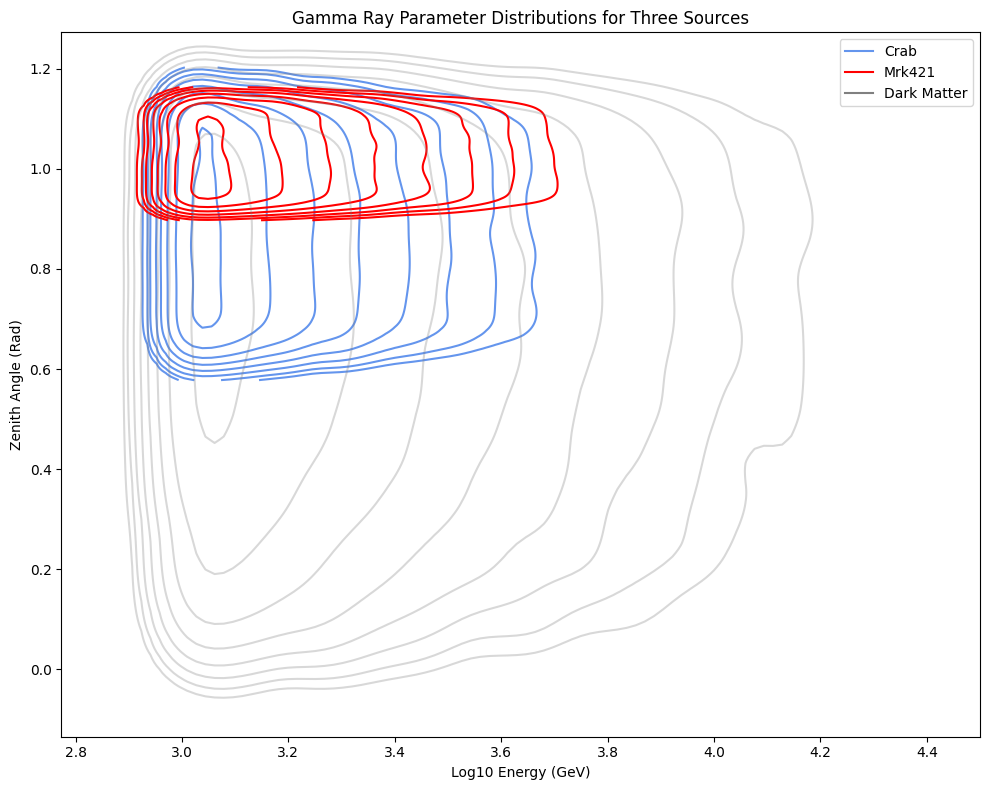

In [28]:
import matplotlib.lines as lines
import cr_sources as crs
import importlib
importlib.reload(crs)

fig, ax = plt.subplots(figsize=(10, 8))
crab_trajectory = crs.get_source_trajectory("crab", -15)
crab_min_zenith = np.deg2rad(90 - np.array(crab_trajectory.alt).max())

mrk_trajectory = crs.get_source_trajectory("mrk421", -15)
mrk_min_zenith = np.deg2rad(90 - np.array(mrk_trajectory.alt).max())
colors = ["cornflowerblue", "red", "grey"]
levels = [0.00625, 0.0125, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8]

i = 0
for split_id, differential_flux, min_zenith, color, alpha in zip(
    [1, 3, 3], 
    [crs.differential_crab_flux, crs.differential_mrk421_flux, crs.differential_dm_flux],
    [crab_min_zenith, mrk_min_zenith, 0],
    colors,
    [1, 1, 0.3]
):
    split_df = manifest[(manifest["split"] == split_id) & (manifest["zenith"] >= min_zenith)]
    if precomputed_weighters[i] is None:
        weighter = te.SplitParameterWeights(
            unfiltered_manifest,
            split_df,
            differential_flux,
            40
        )
        precomputed_weighters[i] = weighter
    else:
        weighter = precomputed_weighters[i]
    i += 1
    split_df["weight"] = weighter.get_weight(split_df["log10_energy"], split_df["zenith"])
    kde_df = split_df.sample(n=30_000)
    sns.kdeplot(
        y = kde_df["zenith"], 
        x = kde_df["log10_energy"], 
        weights=split_df["weight"],
        ax = ax, 
        levels= levels, 
        alpha = alpha,
        color= color
    )
    # ax[i, 2].scatter(nonzero_df["zenith"], nonzero_df["log10_energy"], s=4, alpha=0.1)


handles = [lines.Line2D([0], [0], color=color) for color in colors]
labels = ["Crab", "Mrk421", "Dark Matter"]
plt.legend(handles, labels)

ax.set_ylabel("Zenith Angle (Rad)")
ax.set_xlabel("Log10 Energy (GeV)")
ax.set_xlim(right=4.5)
ax.set_title("Gamma Ray Parameter Distributions for Three Sources")
fig.tight_layout()

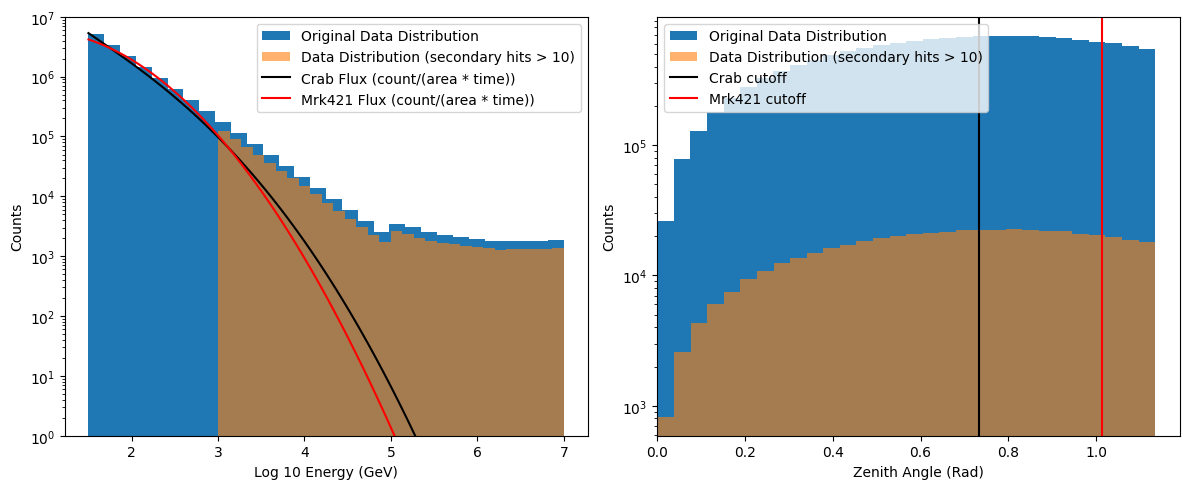

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
num_bins=30
flux_grid = np.linspace(1.5, 6, 100)
crab_trajectory = rev.get_source_trajectory("crab", -20)
mrk_trajectory = rev.get_source_trajectory("mrk421", -20)
crab_min_zenith = np.deg2rad(90 - np.max(np.array(crab_trajectory.alt)))
mrk_min_zenith = np.deg2rad(90 - np.max(np.array(mrk_trajectory.alt)))

i = 0
split_df = manifest
nonzero_df = split_df.query("log10_energy >= 3")
ax[0].hist(split_df["log10_energy"], bins=num_bins, label="Original Data Distribution")
ax[0].hist(nonzero_df["log10_energy"], bins=num_bins, alpha=0.6, label="Data Distribution (secondary hits > 10)")
if i == 0:
    ax[0].plot(flux_grid, 10**rev.log10_crab_flux(flux_grid) * 3e15, label="Crab Flux (count/(area * time))", color="black")
    ax[0].plot(flux_grid, 10**rev.log10_mrk421_flux(flux_grid) * 3e15, label="Mrk421 Flux (count/(area * time))", color="red")
    ax[0].legend()
ax[0].set_xlabel(f"Log 10 Energy (GeV)")
ax[0].set_ylim(1, 1e7)
ax[0].set_yscale("log")
ax[0].set_ylabel("Counts")

ax[1].hist(split_df["zenith"], bins=num_bins, label="Original Data Distribution")
ax[1].hist(nonzero_df["zenith"], bins=num_bins, label="Data Distribution (secondary hits > 10)", alpha=0.6)
ax[1].set_xlabel(f"Zenith Angle (Rad)")    
ax[1].axvline(crab_min_zenith, label="Crab cutoff", color="black")
ax[1].axvline(mrk_min_zenith, label="Mrk421 cutoff", color="red")
ax[1].legend()
ax[1].set_ylabel("Counts")
ax[1].set_xlim(left=0)
ax[1].set_yscale("log")

        
fig.tight_layout()

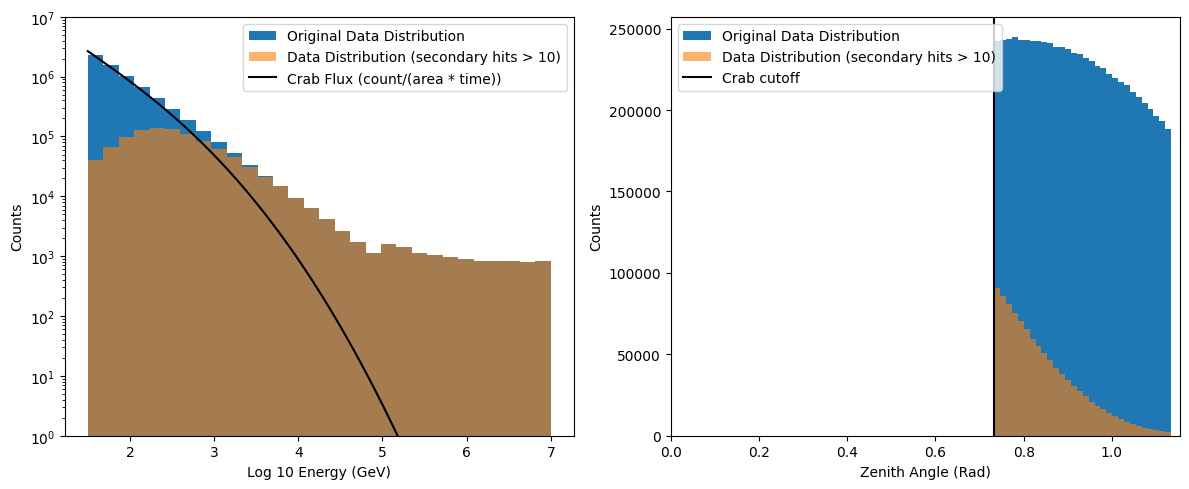

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
num_bins=30
flux_grid = np.linspace(1.5, 6, 100)
crab_trajectory = rev.get_source_trajectory("crab", -20)
mrk_trajectory = rev.get_source_trajectory("mrk421", -20)
crab_min_zenith = np.deg2rad(90 - np.max(np.array(crab_trajectory.alt)))
mrk_min_zenith = np.deg2rad(90 - np.max(np.array(mrk_trajectory.alt)))

i = 0
split_df = manifest[manifest["zenith"] >= crab_min_zenith]
nonzero_df = split_df.query("num_features >= 10")
ax[0].hist(split_df["log10_energy"], bins=num_bins, label="Original Data Distribution")
ax[0].hist(nonzero_df["log10_energy"], bins=num_bins, alpha=0.6, label="Data Distribution (secondary hits > 10)")
if i == 0:
    ax[0].plot(flux_grid, 10**rev.log10_crab_flux(flux_grid) * 1.5e15, label="Crab Flux (count/(area * time))", color="black")
    # ax[0].plot(flux_grid, 10**rev.log10_mrk421_flux(flux_grid) * 3e15, label="Mrk421 Flux", color="red")
    ax[0].legend()
ax[0].set_xlabel(f"Log 10 Energy (GeV)")
ax[0].set_ylim(1, 1e7)
ax[0].set_yscale("log")
ax[0].set_ylabel("Counts")

ax[1].hist(split_df["zenith"], bins=num_bins, label="Original Data Distribution")
ax[1].hist(nonzero_df["zenith"], bins=num_bins, label="Data Distribution (secondary hits > 10)", alpha=0.6)
ax[1].set_xlabel(f"Zenith Angle (Rad)")    
ax[1].axvline(crab_min_zenith, label="Crab cutoff", color="black")
# ax[1].axvline(mrk_min_zenith, label="mrk cutoff", color="red")
ax[1].legend()
ax[1].set_ylabel("Counts")
ax[1].set_xlim(left=0)

        
fig.tight_layout()

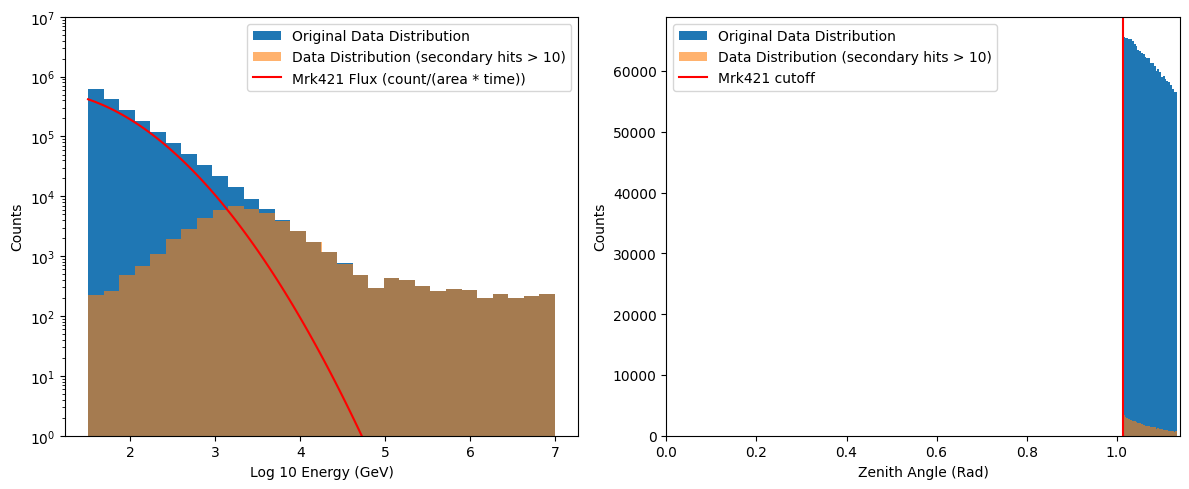

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
num_bins=30
flux_grid = np.linspace(1.5, 6, 100)
crab_trajectory = rev.get_source_trajectory("crab", -20)
mrk_trajectory = rev.get_source_trajectory("mrk421", -20)
crab_min_zenith = np.deg2rad(90 - np.max(np.array(crab_trajectory.alt)))
mrk_min_zenith = np.deg2rad(90 - np.max(np.array(mrk_trajectory.alt)))

i = 0
split_df = manifest[manifest["zenith"] >= mrk_min_zenith]
nonzero_df = split_df.query("num_features >= 10")
ax[0].hist(split_df["log10_energy"], bins=num_bins, label="Original Data Distribution")
ax[0].hist(nonzero_df["log10_energy"], bins=num_bins, alpha=0.6, label="Data Distribution (secondary hits > 10)")
if i == 0:
    # ax[0].plot(flux_grid, 10**rev.log10_crab_flux(flux_grid) * 1.5e15, label="Crab Flux (count/(area * time))", color="black")
    ax[0].plot(flux_grid, 10**rev.log10_mrk421_flux(flux_grid) * 3e14, label="Mrk421 Flux (count/(area * time))", color="red")
    ax[0].legend()
ax[0].set_xlabel(f"Log 10 Energy (GeV)")
ax[0].set_ylim(1, 1e7)
ax[0].set_yscale("log")
ax[0].set_ylabel("Counts")

ax[1].hist(split_df["zenith"], bins=num_bins, label="Original Data Distribution")
ax[1].hist(nonzero_df["zenith"], bins=num_bins, label="Data Distribution (secondary hits > 10)", alpha=0.6)
ax[1].set_xlabel(f"Zenith Angle (Rad)")    
# ax[1].axvline(crab_min_zenith, label="Crab cutoff", color="black")
ax[1].axvline(mrk_min_zenith, label="Mrk421 cutoff", color="red")
ax[1].legend()
ax[1].set_ylabel("Counts")
ax[1].set_xlim(left=0)

        
fig.tight_layout()

# Examples of sets

In [17]:
test_obs = test_ds[12]
assert test_obs is not None
test_obs["params"]

tensor([ 3.1774,  0.9406, -0.9075], device='cuda:1')

In [3]:
from tqdm import tqdm
energies = list()
sizes = list()
num_features = list()
full_param_grid=pos.get_param_grid(
    config.eval_param_mins,
    config.eval_param_maxes,
    30
)

for obs in tqdm(test_ds):
    if obs is None:
        continue

    hpd_set, _ = pos.get_hpd_set(
        model,
        full_param_grid,
        0.9,
        obs["features"],
        config.train_param_mins,
        config.train_param_maxes,
        "joint"
    )
    
    energies.append(obs['params'][0].item())
    sizes.append(hpd_set.numel()/angle_param_grid.numel())
    num_features.append(torch.nonzero(obs['features'][0]).shape[0])

  0%|          | 1/7966 [00:00<1:17:07,  1.72it/s]


NameError: name 'angle_param_grid' is not defined

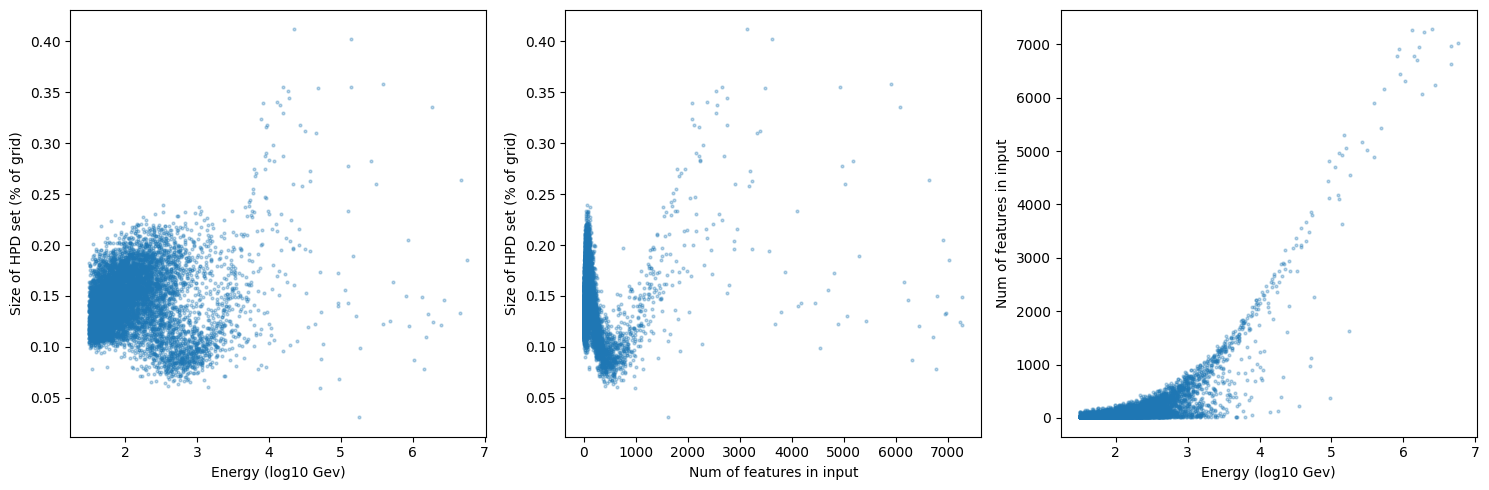

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(energies, sizes, s=4, alpha = 0.3)
ax[0].set_xlabel("Energy (log10 Gev)")
ax[0].set_ylabel("Size of HPD set (% of grid)")
ax[1].scatter(num_features, sizes, s=4, alpha = 0.3)
ax[1].set_ylabel("Size of HPD set (% of grid)")
ax[1].set_xlabel("Num of features in input")

ax[2].scatter(energies, num_features, s=4, alpha = 0.3)
ax[2].set_xlabel("Energy (log10 Gev)")
ax[2].set_ylabel("Num of features in input")

fig.tight_layout()

(0.20000000298023224, 1.1344640137963142)

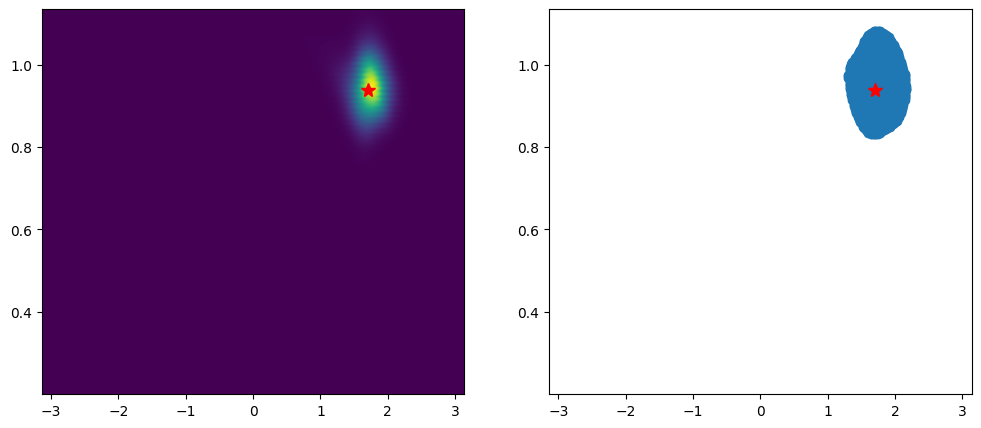

In [4]:
import importlib
import nde_models
importlib.reload(pos)

angle_param_grid=pos.get_param_grid(
    config.eval_param_mins,
    config.eval_param_maxes,
    config.eval_grid_num_points,
    fixed_energy=test_obs['params'][0].item()
)
scaled_angle_param_grid = (angle_param_grid - config.train_param_mins)/(config.train_param_maxes - config.train_param_mins)

log_probs, _ = nde_models.log_probs(model, test_obs['features'][None], scaled_angle_param_grid.to(model.device))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(angle_param_grid[:, 2], angle_param_grid[:, 1], c=torch.exp(log_probs).cpu())
ax[0].plot(test_obs['params'][2].cpu(), test_obs['params'][1].cpu(), color="red", marker="*", markersize=10)
ax[0].set_xlim(config.eval_param_mins[2], config.eval_param_maxes[2])
ax[0].set_ylim(config.eval_param_mins[1], config.eval_param_maxes[1])

hpd_set, _ = pos.get_hpd_set(
    model,
    angle_param_grid,
    0.9,
    test_obs["features"],
    config.train_param_mins,
    config.train_param_maxes,
    "joint"
)
ax[1].scatter(hpd_set[:, 2], hpd_set[:, 1])
ax[1].plot(test_obs['params'][2].cpu(), test_obs['params'][1].cpu(), color="red", marker="*", markersize=10)
ax[1].set_xlim(config.eval_param_mins[2], config.eval_param_maxes[2])
ax[1].set_ylim(config.eval_param_mins[1], config.eval_param_maxes[1])

Text(0.5, 1.0, 'Energy HPD Set')

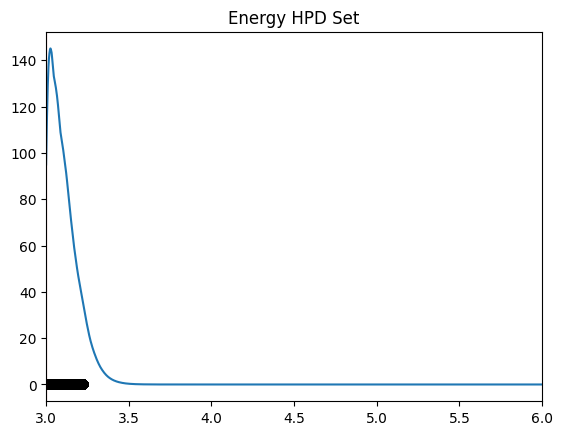

In [6]:
import importlib
import nde_models
importlib.reload(pos)

energy_param_grid=pos.get_param_grid(
    config.eval_param_mins,
    config.eval_param_maxes,
    config.eval_grid_num_points,
    fixed_zenith=test_obs['params'][1].item(),
    fixed_azimuth=test_obs['params'][2].item()
)
scaled_energy_param_grid = (energy_param_grid - config.train_param_mins)/(config.train_param_maxes - config.train_param_mins)

log_probs, _ = nde_models.log_probs(model, test_obs['features'][None], scaled_energy_param_grid.to(model.device))

fig, ax = plt.subplots()
ax = [ax]
ax[0].plot(energy_param_grid[:, 0], torch.exp(log_probs.cpu()).numpy())
ax[0].axvline(test_obs['params'][0].cpu(), color="red")
ax[0].set_xlim(config.eval_param_mins[0], config.eval_param_maxes[0])

hpd_set, _ = pos.get_hpd_set(
    model,
    energy_param_grid,
    0.9,
    test_obs["features"],
    config.train_param_mins,
    config.train_param_maxes,
    "joint"
)
ax[0].scatter(hpd_set[:, 0], [0]*hpd_set.shape[0], color="black")
ax[0].set_title("Energy HPD Set")

In [9]:
import importlib 
importlib.reload(pos)

joint_hpd_hits, joint_hpd_sizes, param_values, weights, event_ids = pos.joint_hpd_coverage_and_size(
    0.9,
    model,
    test_ds,
    config.train_param_mins,
    config.train_param_maxes,
    config.eval_param_mins,
    config.eval_param_maxes,
    config.eval_grid_num_points,
    limit_count=2000
)

HPD Coverage and Size:   0%|          | 2/42757 [00:00<59:27, 11.98it/s]

HPD Coverage and Size:   5%|▍         | 2000/42757 [02:43<55:32, 12.23it/s]  


In [10]:
param_values = np.stack(param_values)
joint_hpd_hits = np.array(joint_hpd_hits)
joint_hpd_sizes = np.array(joint_hpd_sizes)

test_energy_quantiles = np.quantile(param_values[:, 0], np.linspace(0, 1, 20))
test_zenith_quantiles = np.quantile(param_values[:, 1], np.linspace(0, 1, 20))
test_azimuth_quantiles = np.quantile(param_values[:, 2], np.linspace(0, 1, 20))

energy_q_coverage = list()
energy_q_size = list()
energy_q_midpoints = list()
for q_lower, q_upper in zip(test_energy_quantiles[:-1], test_energy_quantiles[1:]):
    mask = (param_values[:, 0] >= q_lower) & (param_values[:, 0] < q_upper)
    energy_q_coverage.append(joint_hpd_hits[mask].mean())
    energy_q_size.append(joint_hpd_sizes[mask].mean())
    energy_q_midpoints.append((q_lower + q_upper)/2)

angle_q_coverage = list()
angle_q_size = list()
angle_q_midpoints = list()
for zq_lower, zq_upper in zip(test_zenith_quantiles[:-1], test_zenith_quantiles[1:]):
    for aq_lower, aq_upper in zip(test_azimuth_quantiles[:-1], test_azimuth_quantiles[1:]):
        mask = (param_values[:, 1] >= zq_lower) & (param_values[:, 1] < zq_upper) & (param_values[:, 2] >= aq_lower) & (param_values[:, 2] < aq_upper)
        angle_q_coverage.append(joint_hpd_hits[mask].mean())
        angle_q_size.append(joint_hpd_sizes[mask].mean())
        angle_q_midpoints.append([(zq_lower + zq_upper)/2, (aq_lower + aq_upper)/2])

/tmp/user/3387/ipykernel_567713/534003359.py:24: RuntimeWarning: Mean of empty slice.
  angle_q_coverage.append(joint_hpd_hits[mask].mean())
/home/export/ajshen/miniconda3/envs/pytorch_gpu/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/user/3387/ipykernel_567713/534003359.py:25: RuntimeWarning: Mean of empty slice.
  angle_q_size.append(joint_hpd_sizes[mask].mean())


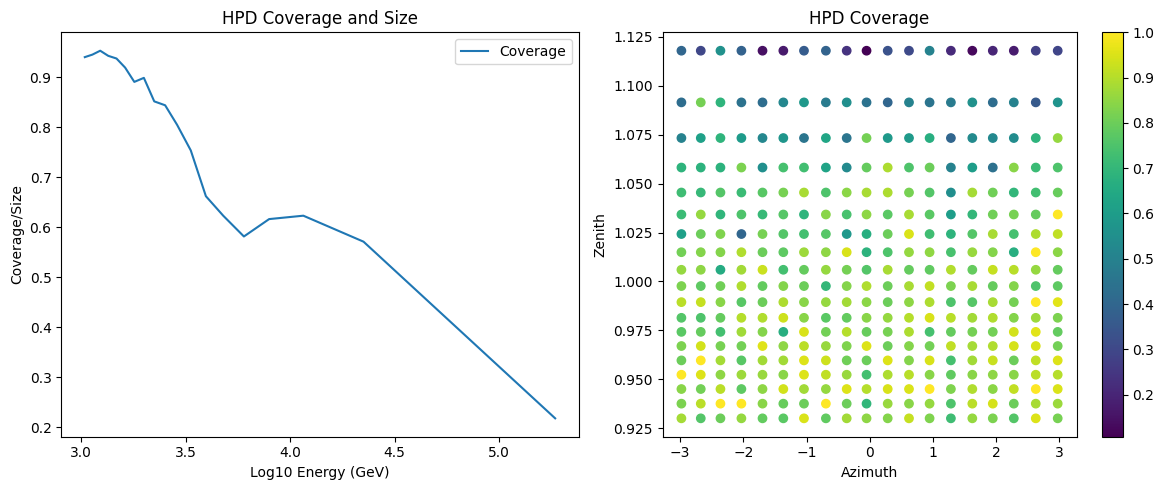

In [43]:
angle_q_midpoints = np.array(angle_q_midpoints)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(energy_q_midpoints, energy_q_coverage, label="Coverage")
# ax[0].plot(energy_q_midpoints, energy_q_size, label="Size")
ax[0].set_title("HPD Coverage and Size")
ax[0].set_xlabel("Log10 Energy (GeV)")
ax[0].set_ylabel("Coverage/Size")
ax[0].legend()
color_pos = ax[1].scatter(angle_q_midpoints[:, 1], angle_q_midpoints[:, 0], c=angle_q_coverage)
ax[1].set_title("HPD Coverage")
ax[1].set_xlabel("Azimuth")
ax[1].set_ylabel("Zenith")

fig.colorbar(color_pos)

# color_pos = ax[2].scatter(angle_q_midpoints[:, 1], angle_q_midpoints[:, 0], c=angle_q_size)
# ax[2].set_title("HPD Size")
# ax[2].set_xlabel("Azimuth")
# ax[2].set_ylabel("Zenith")
# fig.colorbar(color_pos)
fig.tight_layout()

In [44]:
import posteriors as pos
importlib.reload(pos)

w_param_values, joint_waldo_sizes, joint_waldo_hits, weights = pos.waldo_coverage_and_size(
    qr=qr,
    model=model,
    ds=test_ds,
    train_param_mins=config.train_param_mins,
    train_param_maxes=config.train_param_maxes,
    eval_param_mins=config.eval_param_mins,
    eval_param_maxes=config.eval_param_maxes,
    param_grid_num_points=config.eval_grid_num_points,
    num_posterior_samples=config.calibration_num_posterior_samples,
    limit_count=None
)

Waldo Metrics: 100%|██████████| 7966/7966 [01:53<00:00, 70.40it/s]


In [45]:
param_values = np.stack(param_values)

test_energy_quantiles = np.quantile(param_values[:, 0], np.linspace(0, 1, 20))
test_zenith_quantiles = np.quantile(param_values[:, 1], np.linspace(0, 1, 20))
test_azimuth_quantiles = np.quantile(param_values[:, 2], np.linspace(0, 1, 20))

energy_q_coverage = list()
energy_q_size = list()
energy_q_midpoints = list()
for q_lower, q_upper in zip(test_energy_quantiles[:-1], test_energy_quantiles[1:]):
    mask = (param_values[:, 0] >= q_lower) & (param_values[:, 0] < q_upper)
    energy_q_coverage.append(joint_waldo_hits[mask].mean())
    energy_q_size.append(joint_waldo_sizes[mask].mean())
    energy_q_midpoints.append((q_lower + q_upper)/2)

angle_q_coverage = list()
angle_q_size = list()
angle_q_midpoints = list()
for zq_lower, zq_upper in zip(test_zenith_quantiles[:-1], test_zenith_quantiles[1:]):
    for aq_lower, aq_upper in zip(test_azimuth_quantiles[:-1], test_azimuth_quantiles[1:]):
        mask = (param_values[:, 1] >= zq_lower) & (param_values[:, 1] < zq_upper) & (param_values[:, 2] >= aq_lower) & (param_values[:, 2] < aq_upper)
        angle_q_coverage.append(joint_waldo_hits[mask].mean())
        angle_q_size.append(joint_waldo_sizes[mask].mean())
        angle_q_midpoints.append([(zq_lower + zq_upper)/2, (aq_lower + aq_upper)/2])
angle_q_midpoints = np.array(angle_q_midpoints)

NameError: name 'energy_q_midpoints' is not defined

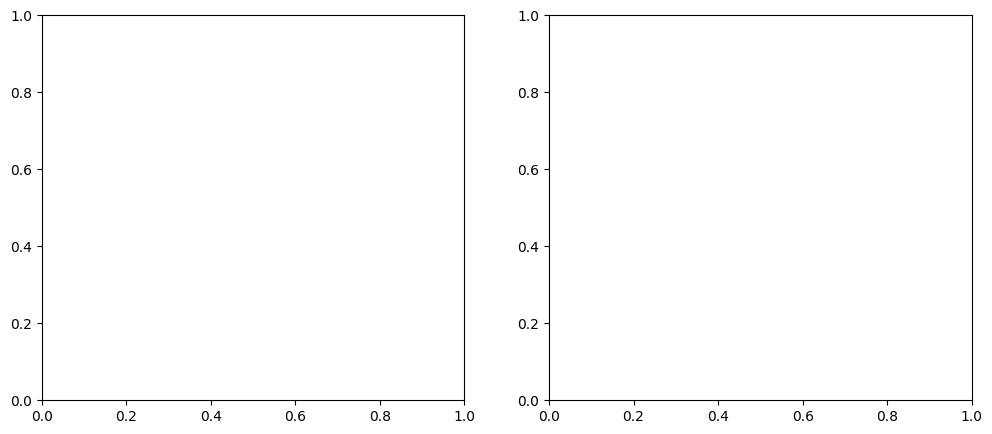

In [30]:


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(energy_q_midpoints, energy_q_coverage, label="Coverage")
# ax[0].plot(energy_q_midpoints, energy_q_size, label="Size")
ax[0].set_title("Waldo Coverage")
ax[0].set_xlabel("Log10 Energy (GeV)")
ax[0].set_ylabel("Coverage")
ax[0].legend()

color_pos = ax[1].scatter(angle_q_midpoints[:, 1], angle_q_midpoints[:, 0], c=angle_q_coverage)
ax[1].set_title("Waldo Coverage")
ax[1].set_xlabel("Azimuth")
ax[1].set_ylabel("Zenith")
fig.colorbar(color_pos)

# color_pos = ax[2].scatter(angle_q_midpoints[:, 1], angle_q_midpoints[:, 0], c=angle_q_size)
# ax[2].set_title("Waldo Size")
# ax[2].set_xlabel("Azimuth")
# ax[2].set_ylabel("Zenith")
# fig.colorbar(color_pos)
fig.tight_layout()

In [20]:
import numpy as np
param_values = np.stack(param_values)
joint_hpd_hits = np.array(joint_hpd_hits)
energy_quantiles = np.quantile(param_values[:, 0], np.linspace(0, 1, 10))
print(f"Overall Coverage {joint_hpd_hits.mean()}")
for i in range(len(energy_quantiles) - 1):
    mask = (param_values[:, 0] >= energy_quantiles[i]) &  (param_values[:, 0] < energy_quantiles[i + 1])
    print(joint_hpd_hits[mask].mean())


Overall Coverage 0.8769716088328076
0.9154929577464789
1.0
0.9714285714285714
0.8873239436619719
0.8571428571428571
0.7857142857142857
0.8028169014084507
0.9285714285714286
0.7428571428571429


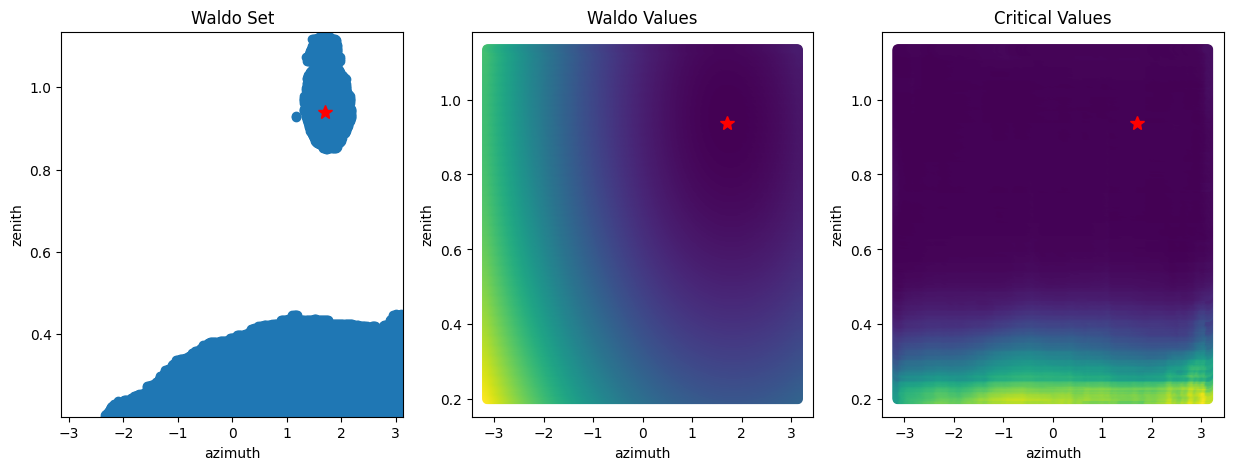

In [7]:
import importlib
importlib.reload(pos)


angle_param_grid=pos.get_param_grid(
    config.eval_param_mins,
    config.eval_param_maxes,
    config.eval_grid_num_points,
    fixed_energy=test_obs['params'][0].item()
)
waldo_set, ts_over_grid, critical_values_over_grid = pos.waldo_confidence_set(
    qr=qr,
    model=model,
    num_posterior_samples=config.calibration_num_posterior_samples,
    param_grid=angle_param_grid,
    train_param_mins=config.train_param_mins,
    train_param_maxes=config.train_param_maxes,
    scaled_features=test_obs['features']
)
waldo_set = waldo_set.cpu()
ts_over_grid = ts_over_grid.cpu()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(waldo_set[:, 2], waldo_set[:, 1])
ax[0].plot(test_obs['params'][2].cpu(), test_obs['params'][1].cpu(), color="red", marker="*", markersize=10)
ax[0].set_xlim(config.eval_param_mins[2], config.eval_param_maxes[2])
ax[0].set_ylim(config.eval_param_mins[1], config.eval_param_maxes[1])
ax[0].set_title("Waldo Set")

ax[1].scatter(angle_param_grid[:, 2], angle_param_grid[:, 1], c=ts_over_grid)
ax[1].set_title("Waldo Values")
ax[1].plot(test_obs['params'][2].cpu(), test_obs['params'][1].cpu(), color="red", marker="*", markersize=10)

ax[2].scatter(angle_param_grid[:, 2], angle_param_grid[:, 1], c=critical_values_over_grid)
ax[2].plot(test_obs['params'][2].cpu(), test_obs['params'][1].cpu(), color="red", marker="*", markersize=10)
ax[2].set_title("Critical Values")

for i in range(3):
    ax[i].set_xlabel("azimuth")
    ax[i].set_ylabel("zenith")

(-0.1, 50.0)

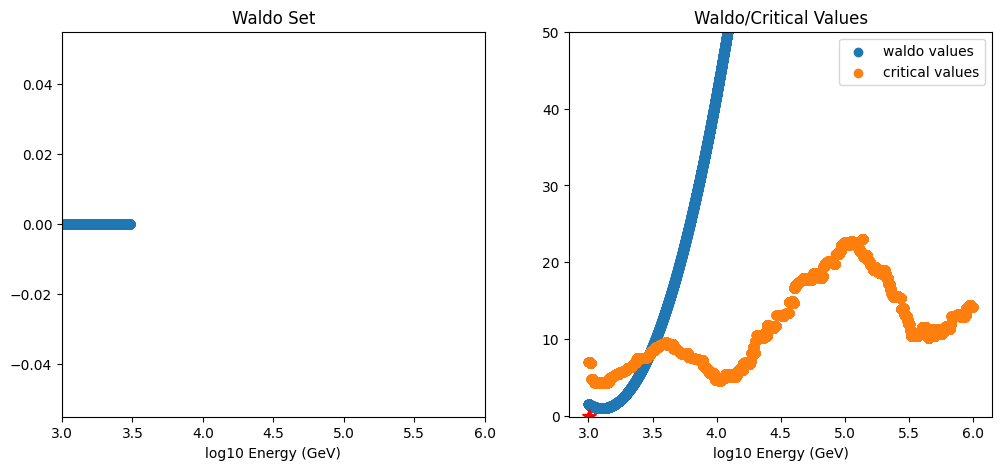

In [8]:
import importlib
importlib.reload(pos)

energy_param_grid=pos.get_param_grid(
    config.eval_param_mins,
    config.eval_param_maxes,
    config.eval_grid_num_points,
    fixed_zenith=test_obs['params'][1].item(),
    fixed_azimuth=test_obs['params'][2].item()
)
waldo_set, ts_over_grid, critical_values_over_grid = pos.waldo_confidence_set(
    qr=qr,
    model=model,
    num_posterior_samples=config.calibration_num_posterior_samples,
    param_grid=energy_param_grid,
    train_param_mins=config.train_param_mins,
    train_param_maxes=config.train_param_maxes,
    scaled_features=test_obs['features']
)
ts_over_grid = ts_over_grid.cpu()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(waldo_set[:, 0], [0] * waldo_set.shape[0])
ax[0].axvline(test_obs['params'][0].cpu(), color="red")
ax[0].set_xlim(config.eval_param_mins[0], config.eval_param_maxes[0])
ax[0].set_title("Waldo Set")
ax[0].set_xlabel("log10 Energy (GeV)")

ax[1].scatter(energy_param_grid[:, 0], ts_over_grid, label="waldo values")
ax[1].set_title("Waldo/Critical Values")
ax[1].plot(test_obs['params'][0].cpu(), 0, color="red", marker="*", markersize=10)
ax[1].scatter(energy_param_grid[:, 0], critical_values_over_grid, label="critical values")

# cutoff_x = [i for i in range(len(cutoff_list)) if cutoff_list[i] > -1]
# ax[1].plot(cutoff_x, [c for c in cutoff_list if c > -1], label="local estimates of cutoff", color="black")
ax[1].set_xlabel("log10 Energy (GeV)")
ax[1].legend()
ax[1].set_ylim(-0.1, 50)

# for i in range(3):
#     ax[i].set_xlabel("azimuth")
#     ax[i].set_ylabel("zenith")

In [6]:
import importlib
import nde_models
importlib.reload(pos)
cal_loader = torch.utils.data.DataLoader(
    cal_ds,
    batch_size=32,
    collate_fn=nde_models.img_collate
)

for batch in cal_loader:
    break 
te.scale_batch_params_inplace(batch, config.train_param_mins, config.train_param_maxes)

_, _, fast_waldos = pos.fast_waldo_evaluate(
    model,
    batch['params'],
    batch['features'][0, None].repeat(31, 1, 1, 1),
    1000
)

# slow_waldos = waldo.evaluate(
#     parameters=batch['params'].cpu(),
#     samples=batch['features'].cpu(),
#     mode='critical_values'
# )

fast_waldos

tensor([20.9523, 23.3655, 51.0848,  1.7086, 14.4621,  6.8580,  4.4410, 27.2878,
        31.6188, 70.9287, 33.1802, 26.4974, 25.2987, 27.4271, 14.9045, 41.4615,
        76.5679, 41.9257, 62.0034, 64.6742, 52.8893, 44.6656, 91.8216, 26.7398,
         6.7461,  1.7363,  1.9645, 22.3208, 44.6396, 52.6779, 18.6256],
       device='cuda:1')

# Set grids

In [11]:
from tqdm import tqdm

test_obs_ids = list()
test_energies = list()
test_zeniths = list()
test_azimuths = list()
test_ds.max_shift_radius = 0

for i in tqdm(range(len(test_ds))):
    test_obs = test_ds[i]
    if test_obs is None:
        continue
    test_obs_ids.append(i)
    test_energies.append(test_obs['params'][0].item())
    test_zeniths.append(test_obs['params'][1].item())
    test_azimuths.append(test_obs['params'][2].item())
    
test_energies = np.array(test_energies)
test_zeniths = np.array(test_zeniths)
test_azimuths = np.array(test_azimuths)
test_obs_ids = np.array(test_obs_ids)

100%|██████████| 42757/42757 [01:09<00:00, 611.18it/s]


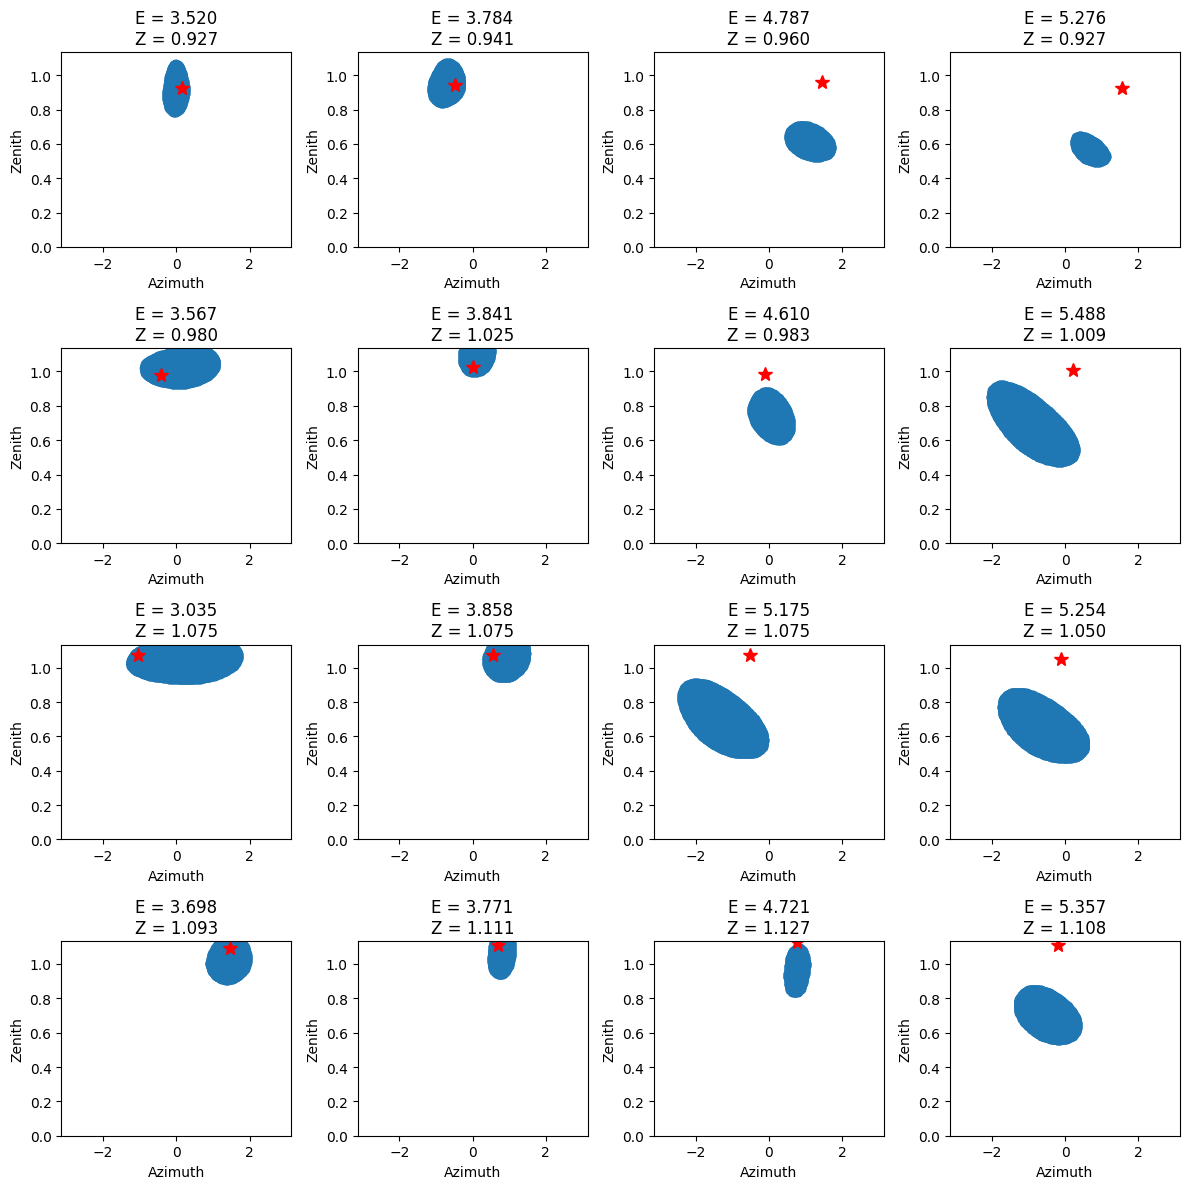

In [14]:
import cr_sources as crs

fig, ax = plt.subplots(4, 4, figsize=(12, 12))

mrk_trajectory = crs.get_source_trajectory("mrk421", -15)
mrk_min_zenith = np.deg2rad(90 - np.max(np.array(mrk_trajectory.alt)))

test_energy_bins = np.linspace(config.eval_param_mins[0], config.eval_param_maxes[0], 5)
test_zenith_bins = np.linspace(mrk_min_zenith, config.eval_param_maxes[1], 5)

for j, test_e_bin_lower, test_e_bin_upper in zip(range(4), test_energy_bins[:-1], test_energy_bins[1:]):
    for i, test_z_bin_lower, test_z_bin_upper in zip(range(4), test_zenith_bins[:-1], test_zenith_bins[1:]):
        mask = (test_energies > test_e_bin_lower) & (test_energies <= test_e_bin_upper) & (test_zeniths > test_z_bin_lower) & (test_zeniths <= test_z_bin_upper) 
        valid_id = np.random.choice(test_obs_ids[mask], 1)[0]
        valid_obs = test_ds[valid_id]
        
        angle_param_grid=pos.get_param_grid(
            config.eval_param_mins,
            config.eval_param_maxes,
            config.eval_grid_num_points,
            fixed_energy=valid_obs['params'][0].item()
        )
        scaled_angle_param_grid = (angle_param_grid - config.train_param_mins)/(config.train_param_maxes - config.train_param_mins)

        hpd_set, _ = pos.get_hpd_set(
            model,
            angle_param_grid,
            0.9,
            valid_obs["features"],
            config.train_param_mins,
            config.train_param_maxes,
            "joint"
        )
        ax[i, j].scatter(hpd_set[:, 2], hpd_set[:, 1])
        ax[i, j].plot(valid_obs['params'][2].cpu(), valid_obs['params'][1].cpu(), color="red", marker="*", markersize=10)
        ax[i, j].set_xlim(config.eval_param_mins[2], config.eval_param_maxes[2])
        ax[i, j].set_ylim(config.eval_param_mins[1], config.eval_param_maxes[1])
        ax[i, j].set_xlabel("Azimuth")
        ax[i, j].set_ylabel("Zenith")
        ax[i, j].set_title(f"E = {valid_obs['params'][0].item():0.3f}\nZ = {valid_obs['params'][1].item():0.3f}")
fig.tight_layout()

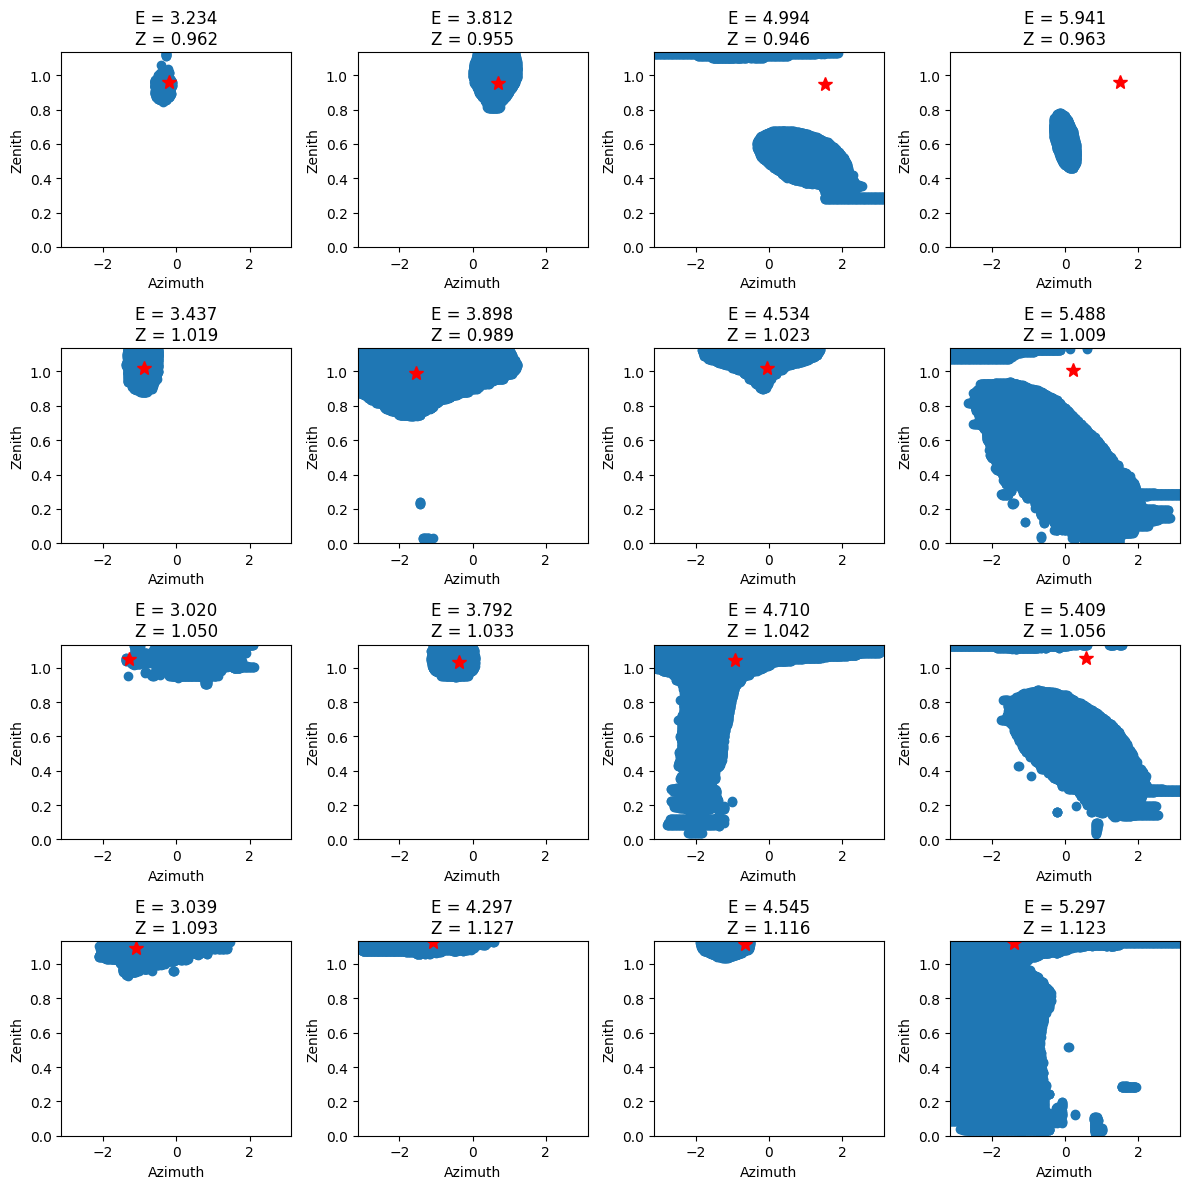

In [16]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))

mrk_trajectory = crs.get_source_trajectory("mrk421", -15)
mrk_min_zenith = np.deg2rad(90 - np.max(np.array(mrk_trajectory.alt)))

test_energy_bins = np.linspace(config.eval_param_mins[0], config.eval_param_maxes[0], 5)
test_zenith_bins = np.linspace(mrk_min_zenith, config.eval_param_maxes[1], 5)

for j, test_e_bin_lower, test_e_bin_upper in zip(range(4), test_energy_bins[:-1], test_energy_bins[1:]):
    for i, test_z_bin_lower, test_z_bin_upper in zip(range(4), test_zenith_bins[:-1], test_zenith_bins[1:]):
        mask = (test_energies > test_e_bin_lower) & (test_energies <= test_e_bin_upper) & (test_zeniths > test_z_bin_lower) & (test_zeniths <= test_z_bin_upper) 
        valid_id = np.random.choice(test_obs_ids[mask], 1)[0]
        valid_obs = test_ds[valid_id]
        
        angle_param_grid=pos.get_param_grid(
            config.eval_param_mins,
            config.eval_param_maxes,
            config.eval_grid_num_points,
            fixed_energy=valid_obs['params'][0].item()
        )
        
        waldo_set, ts_over_grid, critical_values_over_grid = pos.waldo_confidence_set(
            qr=qr,
            model=model,
            num_posterior_samples=config.calibration_num_posterior_samples,
            param_grid=angle_param_grid,
            train_param_mins=config.train_param_mins,
            train_param_maxes=config.train_param_maxes,
            scaled_features=valid_obs['features']
        )
        waldo_set = waldo_set.cpu()
        ts_over_grid = ts_over_grid.cpu()


        ax[i, j].scatter(waldo_set[:, 2], waldo_set[:, 1])
        ax[i, j].plot(valid_obs['params'][2].cpu(), valid_obs['params'][1].cpu(), color="red", marker="*", markersize=10)
        ax[i, j].set_xlim(config.eval_param_mins[2], config.eval_param_maxes[2])
        ax[i, j].set_ylim(config.eval_param_mins[1], config.eval_param_maxes[1])
        ax[i, j].set_xlabel("Azimuth")
        ax[i, j].set_ylabel("Zenith")
        ax[i, j].set_title(f"E = {valid_obs['params'][0].item():0.3f}\nZ = {valid_obs['params'][1].item():0.3f}")
fig.tight_layout()

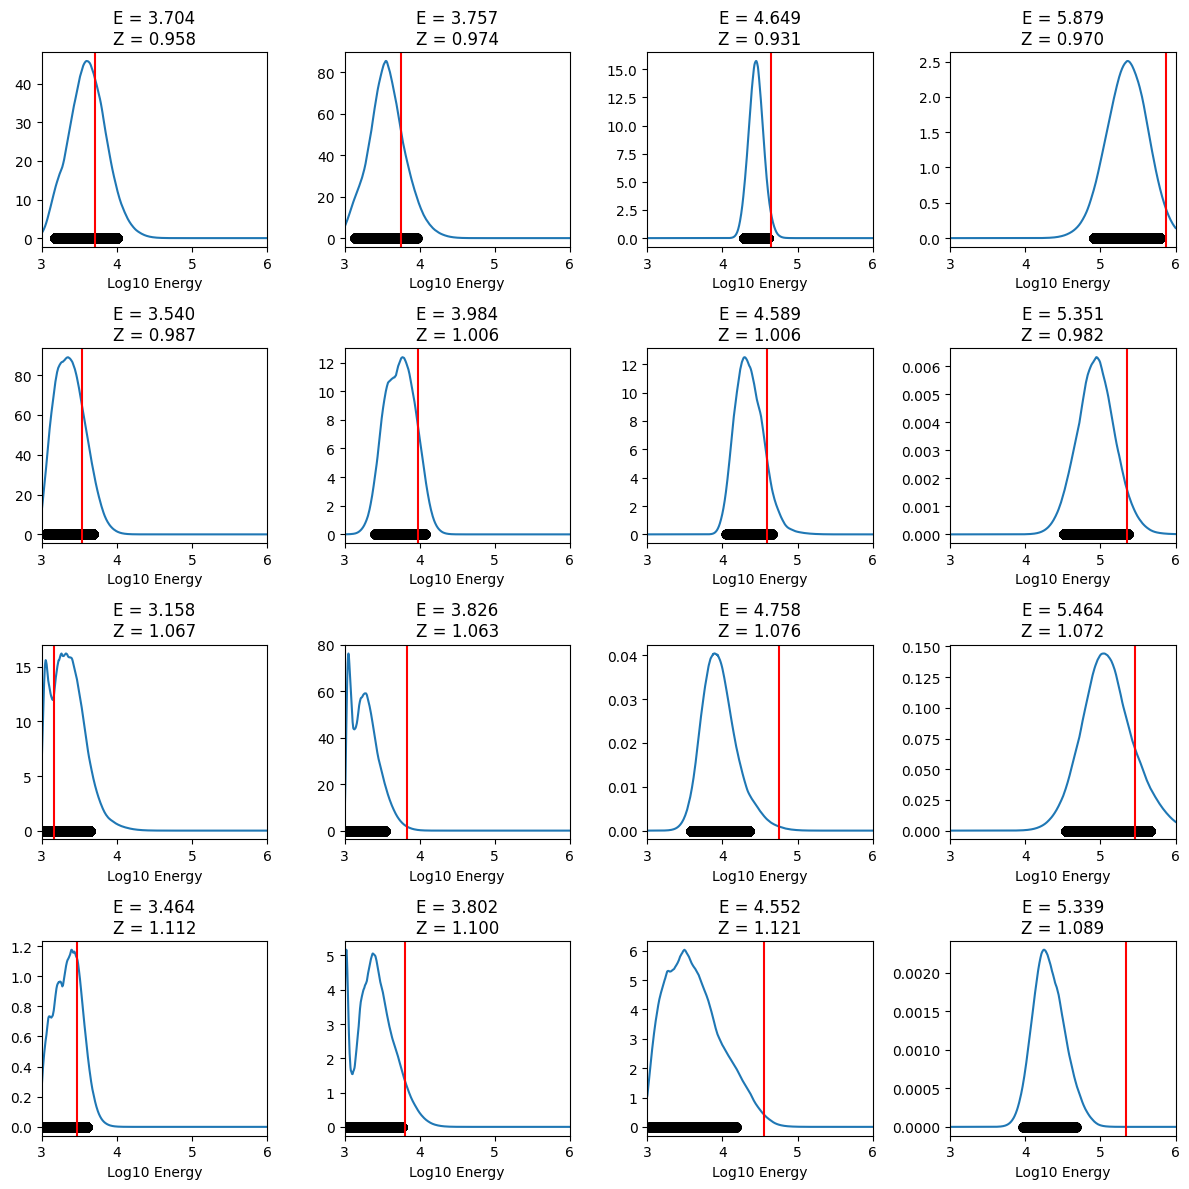

In [37]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))

mrk_trajectory = rev.get_source_trajectory("mrk421", -15)
mrk_min_zenith = np.deg2rad(90 - np.max(np.array(mrk_trajectory.alt)))

test_energy_bins = np.linspace(config.eval_param_mins[0], config.eval_param_maxes[0], 5)
test_zenith_bins = np.linspace(mrk_min_zenith, config.eval_param_maxes[1], 5)

for j, test_e_bin_lower, test_e_bin_upper in zip(range(4), test_energy_bins[:-1], test_energy_bins[1:]):
    for i, test_z_bin_lower, test_z_bin_upper in zip(range(4), test_zenith_bins[:-1], test_zenith_bins[1:]):
        mask = (test_energies > test_e_bin_lower) & (test_energies <= test_e_bin_upper) & (test_zeniths > test_z_bin_lower) & (test_zeniths <= test_z_bin_upper) 
        valid_id = np.random.choice(test_obs_ids[mask], 1)[0]
        valid_obs = test_ds[valid_id]
        
        energy_param_grid=pos.get_param_grid(
            config.eval_param_mins,
            config.eval_param_maxes,
            config.eval_grid_num_points,
            fixed_zenith=valid_obs['params'][1].item(),
            fixed_azimuth=valid_obs['params'][2].item()
        )
        scaled_energy_param_grid = (energy_param_grid - config.train_param_mins)/(config.train_param_maxes - config.train_param_mins)
        
        log_probs, _ = nde_models.log_probs(model, valid_obs['features'][None], scaled_energy_param_grid.to(model.device))

        hpd_set, _ = pos.get_hpd_set(
            model,
            energy_param_grid,
            0.9,
            valid_obs["features"],
            config.train_param_mins,
            config.train_param_maxes,
            "joint"
        )
        ax[i, j].plot(energy_param_grid[:, 0], torch.exp(log_probs.cpu()).numpy())
        ax[i, j].scatter(hpd_set[:, 0], [0]*hpd_set.shape[0], color="black")
        ax[i, j].axvline(valid_obs['params'][0].cpu(), color="red")
        ax[i, j].set_xlim(config.eval_param_mins[0], config.eval_param_maxes[0])
        ax[i, j].set_xlabel("Log10 Energy")
        ax[i, j].set_title(f"E = {valid_obs['params'][0].item():0.3f}\nZ = {valid_obs['params'][1].item():0.3f}")
fig.tight_layout()

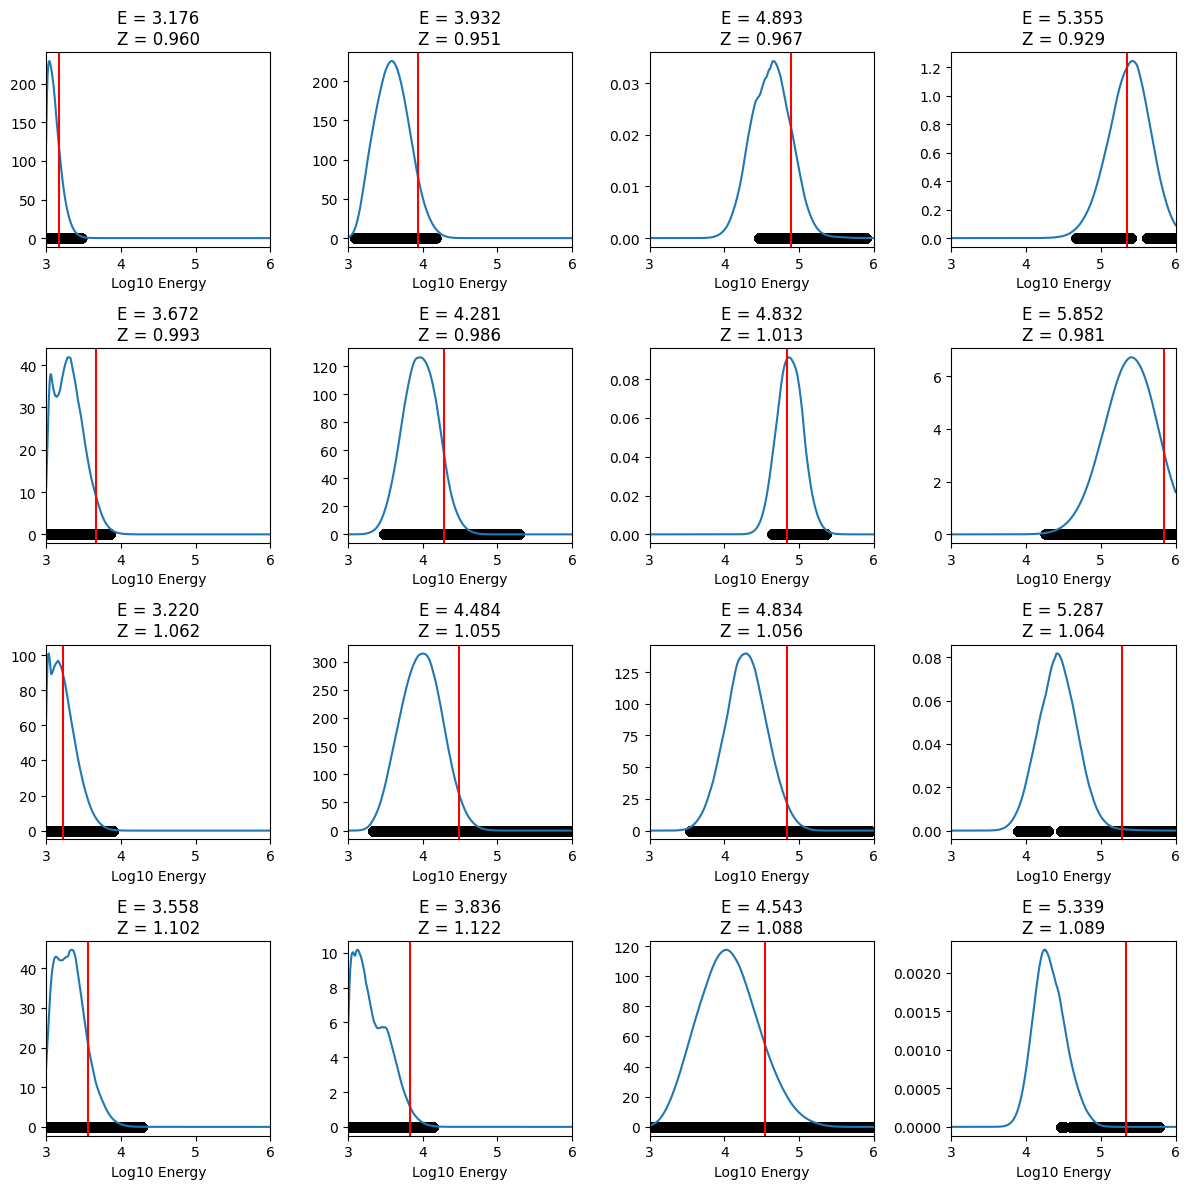

In [38]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))

mrk_trajectory = rev.get_source_trajectory("mrk421", -15)
mrk_min_zenith = np.deg2rad(90 - np.max(np.array(mrk_trajectory.alt)))

test_energy_bins = np.linspace(config.eval_param_mins[0], config.eval_param_maxes[0], 5)
test_zenith_bins = np.linspace(mrk_min_zenith, config.eval_param_maxes[1], 5)

for j, test_e_bin_lower, test_e_bin_upper in zip(range(4), test_energy_bins[:-1], test_energy_bins[1:]):
    for i, test_z_bin_lower, test_z_bin_upper in zip(range(4), test_zenith_bins[:-1], test_zenith_bins[1:]):
        mask = (test_energies > test_e_bin_lower) & (test_energies <= test_e_bin_upper) & (test_zeniths > test_z_bin_lower) & (test_zeniths <= test_z_bin_upper) 
        valid_id = np.random.choice(test_obs_ids[mask], 1)[0]
        valid_obs = test_ds[valid_id]
        
        energy_param_grid=pos.get_param_grid(
            config.eval_param_mins,
            config.eval_param_maxes,
            config.eval_grid_num_points,
            fixed_zenith=valid_obs['params'][1].item(),
            fixed_azimuth=valid_obs['params'][2].item()
        )
        scaled_energy_param_grid = (energy_param_grid - config.train_param_mins)/(config.train_param_maxes - config.train_param_mins)
        
        log_probs, _ = nde_models.log_probs(model, valid_obs['features'][None], scaled_energy_param_grid.to(model.device))

        waldo_set, ts_over_grid, critical_values_over_grid = pos.waldo_confidence_set(
            qr=qr,
            model=model,
            num_posterior_samples=config.calibration_num_posterior_samples,
            param_grid=energy_param_grid,
            train_param_mins=config.train_param_mins,
            train_param_maxes=config.train_param_maxes,
            scaled_features=valid_obs['features']
        )
        ax[i, j].plot(energy_param_grid[:, 0], torch.exp(log_probs.cpu()).numpy())
        ax[i, j].scatter(waldo_set[:, 0], [0]*waldo_set.shape[0], color="black")
        ax[i, j].axvline(valid_obs['params'][0].cpu(), color="red")
        ax[i, j].set_xlim(config.eval_param_mins[0], config.eval_param_maxes[0])
        ax[i, j].set_xlabel("Log10 Energy")
        ax[i, j].set_title(f"E = {valid_obs['params'][0].item():0.3f}\nZ = {valid_obs['params'][1].item():0.3f}")
fig.tight_layout()